# Part 3: Predictive Modelling                                

### 1. Perform    any     cleaning,     exploratory    analysis,    and/or     visualizations     to    use     the    provided  data     for     this    analysis     (a     few     sentences/plots    describing     your    approach    will     suffice).    What  fraction     of     the    observed     users    were     retained?

# Set up Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler




# Data Wrangling

In [2]:
# Open the json data and load it so that you can change it to pandas dataframe

with open("C:/Users/freta/Desktop/ultimate_challenge/ultimate_data_challenge.json") as ult:
    ult_data=json.load(ult)

ultimate_data = pd.DataFrame(ult_data)

In [3]:
# Check the first five observations

ultimate_data.head()

# We can see floats, object, and boolean

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
# check the last five observations

ultimate_data.tail()

#  Here the are few missing values


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [5]:
print(ultimate_data.shape)
# The dataset has 50000 observations and 12 columns

ultimate_data.info()

# All but three variables have no missing values. avg_rating_of_driver has more than 8000 missing values, while phone and 
# avg_rating_by_driver have missing values in hundreds.

# city, last_trip_date, phone, signup_date are data type of object
# ultimate_black_user is boolean
# While the remaining are float64, and int64
# We also have date variables last_trip_date, signup_date

(50000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
# As we mentioned earlier, we have two date variables with datatype object, and we have to change them to datetime

ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data.last_trip_date)
ultimate_data['signup_date'] = pd.to_datetime(ultimate_data.signup_date)

# We also have to change the boolean variable below to int64
ultimate_data['ultimate_black_user'] = ultimate_data['ultimate_black_user'].astype(int)

In [7]:
# find the date the data was pulled

ultimate_data.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [8]:
# Since the variable signup_date is date time for the sake of our machine learning, we will change it into meaningful way 
# ..i.e. we will change is to the number of days since sign up to the date the data was pulled (2014-07-01)

ultimate_data['signup_date'] = 20140701 - ultimate_data['signup_date'].dt.strftime('%Y%m%d').astype(int) 


# Understanding the Target Variable

In [9]:
# The last_trip_date variable is the one that tells us whether the individual is retained or not. In order to do so, lets 
# .. lets describe it first to know the starting and begining dates.

ultimate_data['last_trip_date'].describe()

# we can see that the starting date is 2014-01-01 00:00:00, and the last date is 2014-07-01 00:00:00. Therefore, as per our 
# ..operational definition retention is defined as being last trip date in the preceeding 30 days. Thus, individuals 
# ....will be classified as retained if their last trip date was since since 2014-06-01 and on.

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [10]:
# Lets extract our target variable "is_retained" then

ultimate_data['is_retained'] = (ultimate_data['last_trip_date'] >= datetime.datetime(2014,6,1)).astype(int)

ultimate_data['is_retained'].value_counts()

# The proportion of retained and not retained is 37.6% and 62.4% respectivel which good enough for our 
# machine learning algorithm

0    31196
1    18804
Name: is_retained, dtype: int64

Text(0.5, 1.0, 'Bar plot for the target variable/retention status')

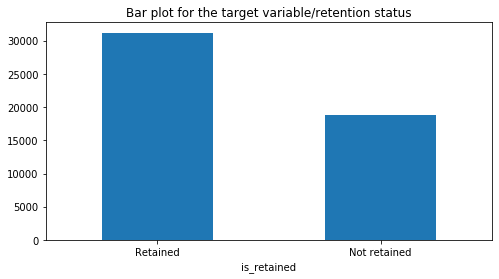

In [11]:
plt.figure(figsize=(8,4))
ultimate_data.groupby(['is_retained'])['is_retained'].count().plot.bar()
plt.xticks(np.arange(2), ["Retained", "Not retained"], rotation=0)
plt.title('Bar plot for the target variable/retention status')



In [12]:
#  Drop the 'last_trip_date'. We don't need it anymore

ultimate_data.drop(['last_trip_date'], axis=1, inplace=True)

# Handling Missing Values

In [13]:
# Lets fill the missing values of the variables the median of their respective columns.

ultimate_data.fillna(ultimate_data.median(), inplace=True)

ultimate_data.info()

# We still have one feature "phone" with missing value. This feature is a categorical feature, that is why it could't be 
# filled by median.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null int32
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
is_retained               50000 non-null int32
dtypes: float64(6), int32(3), int64(1), object(2)
memory usage: 4.0+ MB


In [14]:
# the phone has only two values (iPhone, and Android) with missing values.
# We decided to to fill the missing value with "other"

ultimate_data.phone.fillna("Other", inplace=True)

ultimate_data.phone.value_counts()

# It has now three values iPhone, Android, Other

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

In [15]:
ultimate_data.info()
# Now we don't have missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null int32
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone                     50000 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null int32
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
is_retained               50000 non-null int32
dtypes: float64(6), int32(3), int64(1), object(2)
memory usage: 4.0+ MB


# EDA

In [16]:
ultimate_data.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_retained
count,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,584.45532,4.650038,1.074764,8.849536,0.37708,60.926084,5.796827,4.779050,0.376080
std,3.792684,8.75422,0.575601,0.222336,19.958811,0.48466,37.081503,5.707357,0.445974,0.484405
min,0.000000,570.00000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,577.00000,4.500000,1.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,584.00000,4.900000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,592.00000,5.000000,1.050000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000
max,125.000000,600.00000,5.000000,8.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000


In [17]:
# There is big difference between the mean and the median(50%) for varialbes avg_dist, & surge_pct, 
# there is also a big gap between the 75% and maximum value for variables such as avg_dist avg_surge, 
# ...surge_pct, and trips_in_first_30_days

# The two remarks stated above indicate that the distribution of these variables is skewed.

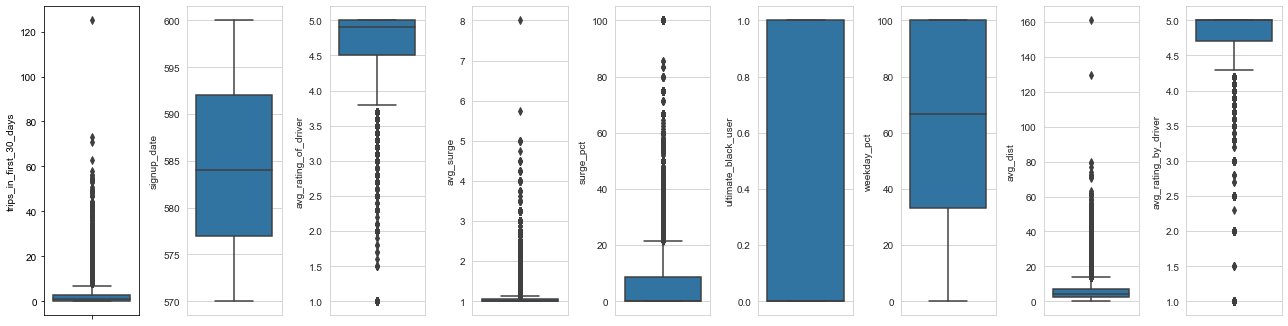

In [18]:
cols = ultimate_data.drop(['phone', 'is_retained', 'city'], axis=1).columns.values

num_cols = len(cols)
num_rows = len(cols)
plt.figure(figsize=(2*num_cols, 5*num_rows))

for i in range(0, len(cols)):
    plt.subplot(num_rows +1, num_cols, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(ultimate_data[cols[i]], orient='v')
    plt.tight_layout()

In [19]:
# Outliers are represented by the dots above and below the wiskers.
# All have outliers except for signup_date, ultimate_black_user, & weekday_pct.

# signup_date is the only feature that looks normally distributed.

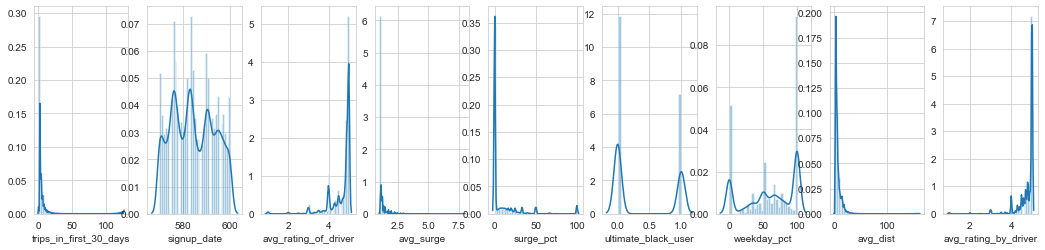

In [20]:
plt.figure(figsize=(2*num_cols, 5*num_rows))

for i in range(0, len(cols)):
    plt.subplot(num_rows +1, num_cols, i+1)
    sns.distplot(ultimate_data[cols[i]], kde=True)

In [21]:
# Here signup_date is multimodal,where as ultimate_black_user, & weekday_pct are bimodal
#  the rest are skewed to either right or left.

is_retained               1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
signup_date               0.020211
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_by_driver     -0.027548
avg_rating_of_driver     -0.041082
avg_dist                 -0.092780
Name: is_retained, dtype: float64

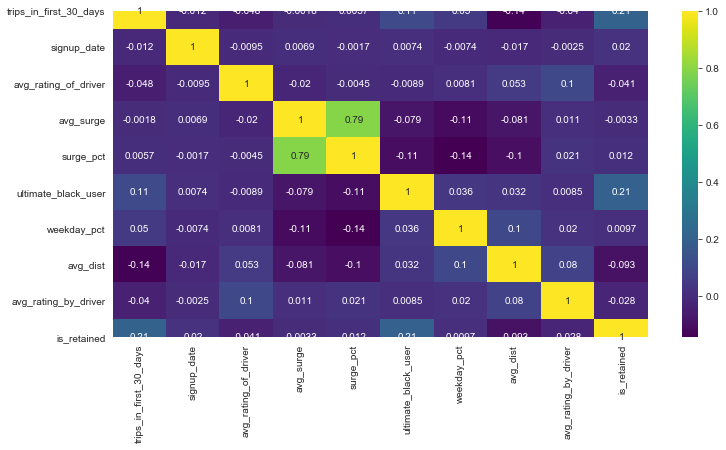

In [22]:
#  Let's create a heatmap that shows the correlation of features with the target variable.
plt.figure(figsize=(12, 6))
cm = ultimate_data.corr()
cm['is_retained'].sort_values(ascending=False)
sns.heatmap(cm, annot=True, cmap="viridis")

cm['is_retained'].sort_values(ascending=False)

# trips_in_first_30_days, ultimate_black_user, and ultimate_black_user are the three most positively correlated features 
# ..with the target variable. While avg_dist is negatively correlated with the target variable.
# However, all of the features has week correlation with the target variable.

#  On the other hand,  avg_surge is highly correlated with surge_pct.This will definitely affect our machine learning model.
# ..Thus we will deal with it later in this section by using VIF.

# Handle Outliers

In [23]:
# Since we have outliers in our dataset, we will remove those below 2nd percentile and/or above 98th percentile

num_df = ultimate_data.select_dtypes(include="number")
cat_df = ultimate_data.select_dtypes(exclude="number")

Q1 = ultimate_data.quantile(0.02)
Q3 = ultimate_data.quantile(0.98)
IQR = Q3 - Q1

idx = ~((ultimate_data < (Q1 - 1.5*IQR)) | (ultimate_data > (Q3 + 1.5*IQR))).any(axis=1)

ultimate_clean = pd.concat([num_df.loc[idx], cat_df.loc[idx]], axis=1)

ultimate_data.shape, ultimate_clean.shape

# we removed 229 observations that lie either below 2 percentile or above 98th percentile

((50000, 12), (49771, 12))

# Handling Categorical Variables

In [24]:
#  We have one categorical feature (phone) that needs to handled so that it can be suitable for machine learning

ultimate_ohe = pd.get_dummies(ultimate_clean, columns=['phone', 'city'])

ultimate_ohe.shape

ultimate_ohe=ultimate_ohe.astype(float)
ultimate_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49771 entries, 0 to 49999
Data columns (total 16 columns):
trips_in_first_30_days    49771 non-null float64
signup_date               49771 non-null float64
avg_rating_of_driver      49771 non-null float64
avg_surge                 49771 non-null float64
surge_pct                 49771 non-null float64
ultimate_black_user       49771 non-null float64
weekday_pct               49771 non-null float64
avg_dist                  49771 non-null float64
avg_rating_by_driver      49771 non-null float64
is_retained               49771 non-null float64
phone_Android             49771 non-null float64
phone_Other               49771 non-null float64
phone_iPhone              49771 non-null float64
city_Astapor              49771 non-null float64
city_King's Landing       49771 non-null float64
city_Winterfell           49771 non-null float64
dtypes: float64(16)
memory usage: 6.5 MB


# Train Test Split

In [25]:
X = ultimate_ohe.drop('is_retained', axis=1)
y = ultimate_ohe.is_retained

X.shape, y.shape

((49771, 15), (49771,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34839, 15), (14932, 15), (34839,), (14932,))

## 2. Build    a    predictive     model     to     help    Ultimate    determine    whether    or    not    a    user    will    be    active  in     their    6th    month     on     the     system.    Discuss    why     you     chose     your    approach,    what  alternatives     you     considered,     and    any     concerns     you    have.    How     valid     is     your    model?  Include    any     key     indicators    of     model    performance.

# Machine Learning Model

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Logistic Regression

roc_auc_score: 0.6751172581703063
Accuracy for Logistic Regresssion is:  0.7196624698633807
Log Loss for the logistic regression : 0.5554292701509019
confusion_matrix for the logistic regression 
: [[7966 1320]
 [2866 2780]]
classification report for logistic regression is 
:                precision    recall  f1-score   support

         0.0       0.74      0.86      0.79      9286
         1.0       0.68      0.49      0.57      5646

    accuracy                           0.72     14932
   macro avg       0.71      0.68      0.68     14932
weighted avg       0.71      0.72      0.71     14932



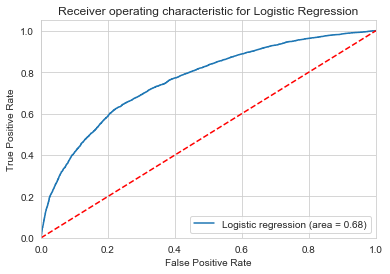

In [28]:
# Instantiate model and fit with the training data

log_reg = LogisticRegression(solver='liblinear', random_state=42).fit(X_train, y_train)

# predict the fitted data

y_pred_logreg = log_reg.predict(X_test)

# calculate and print the roc_auc_score, accuracy score and classification_report

print('roc_auc_score:', roc_auc_score(y_test, y_pred_logreg))
print('Accuracy for Logistic Regresssion is: ', accuracy_score(y_test, y_pred_logreg))

proba_lr = log_reg.predict_proba(X_test)
print('Log Loss for the logistic regression :', log_loss(y_test, proba_lr))

print('confusion_matrix for the logistic regression \n:', confusion_matrix(y_test, y_pred_logreg))

print('classification report for logistic regression is \n: ', classification_report(y_test, y_pred_logreg))

# draw the ROC_AUC curve

fpr, tpr, treshold = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label="Logistic regression (area = %0.2f)" % roc_auc_score(y_test, y_pred_logreg))
plt.plot([0, 1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# KNN

roc_auc_score: 0.725441168201664
accuracy_score: 0.7611840342887758
Log Loss: 0.7836936620327082
confusion_matrix 
: [[8098 1188]
 [2378 3268]]
              precision    recall  f1-score   support

         0.0       0.77      0.87      0.82      9286
         1.0       0.73      0.58      0.65      5646

    accuracy                           0.76     14932
   macro avg       0.75      0.73      0.73     14932
weighted avg       0.76      0.76      0.75     14932

Tuned Model Parameters: {'knn__p': 1, 'knn__n_neighbors': 14}


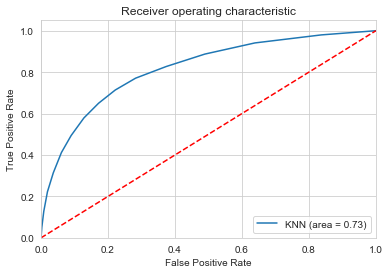

In [29]:
# Setup the pipeline steps for scaling

steps=[('scaler', MinMaxScaler()),
      ('knn', KNeighborsClassifier())]

pipeline=Pipeline(steps)

# Specify the hyperparameter to be tunned

parameters={'knn__n_neighbors' : [10, 12, 13, 14, 15, 16],
           'knn__p' : [1, 2, 3, 4, 5, 6]}

# # Create the GridSearchCV object

cv_knn = RandomizedSearchCV(pipeline, parameters, cv=5)

# #  Fit to the training set

cv_knn.fit(X_train, y_train)

# # predict the fitted data

y_pred_knn = cv_knn.predict(X_test)

# Compute and print metrics (roc_auc_score, accuracy score and classification_report) with the best model parameters


print('roc_auc_score:', roc_auc_score(y_test, y_pred_knn))    

print('accuracy_score:', accuracy_score(y_test, y_pred_knn))  

knn_prob = cv_knn.predict_proba(X_test)

print('Log Loss:', log_loss(y_test, knn_prob))

print('confusion_matrix \n:', confusion_matrix(y_test, y_pred_knn))

print(classification_report(y_test, y_pred_knn))

print("Tuned Model Parameters: {}".format(cv_knn.best_params_))
                       

# draw the ROC_AUC curve

knn_roc=roc_auc_score(y_test, y_pred_knn)

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, cv_knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_knn, tpr_knn, label='KNN (area = %0.2f)' % knn_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('knn_ROC_curve')
plt.show()

# Decision Tree Classifier

roc_auc_score: 0.6952093427507607
accuracy_score: 0.734462898473078
Log Loss:  0.5322325180675324
confusion_matrix 
: [[7951 1335]
 [2630 3016]]
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80      9286
         1.0       0.69      0.53      0.60      5646

    accuracy                           0.73     14932
   macro avg       0.72      0.70      0.70     14932
weighted avg       0.73      0.73      0.73     14932

Tuned Model Parameters: {'min_samples_leaf': 3, 'max_features': 6, 'max_depth': 4, 'criterion': 'entropy'}


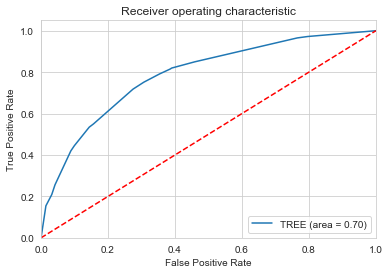

In [30]:
tree = DecisionTreeClassifier()
param_dist = {"max_depth": [2, 3, 4, None],
              "max_features": [2, 3, 4, 5, 6],
              "min_samples_leaf": [1, 2, 3, 4, 5],
              "criterion": ["gini", "entropy"]}

tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)


#  Fit to the training set

tree_cv.fit(X_train, y_train)

# predict the fitted data

y_pred_tree = tree_cv.predict(X_test)

# Compute and print metrics (roc_auc_score, accuracy score and classification_report) with the best model parameters

print('roc_auc_score:', roc_auc_score(y_test, y_pred_tree))                           
print('accuracy_score:', accuracy_score(y_test, y_pred_tree))    

tree_prob = tree_cv.predict_proba(X_test)
print('Log Loss: ', log_loss(y_test, tree_prob))

print('confusion_matrix \n:', confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

print("Tuned Model Parameters: {}".format(tree_cv.best_params_))



# draw the ROC_AUC curve

tree_roc = roc_auc_score(y_test, y_pred_tree)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, tree_cv.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_tree, tpr_tree, label='TREE (area = %0.2f)' % tree_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Tree_ROC_curve')
plt.show()

# Random Forest

roc_auc_score: 0.7620773035316726
accuracy_score: 0.7872354674524511
Log Loss for the Random Forest classifier: 0.4566296474533681
confusion_matrix 
: [[8035 1251]
 [1926 3720]]
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.83      9286
         1.0       0.75      0.66      0.70      5646

    accuracy                           0.79     14932
   macro avg       0.78      0.76      0.77     14932
weighted avg       0.78      0.79      0.78     14932

Tuned Model Parameters: {'n_estimators': 200, 'max_depth': 13}


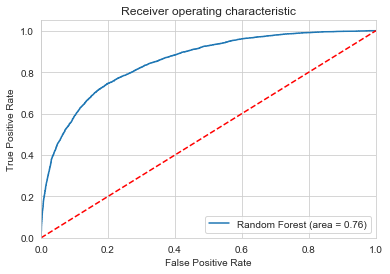

In [31]:
# Instantiate model 

rf = RandomForestClassifier(random_state = 42)

# Specify the hyperparameter to be tunned
rf_para={'n_estimators':[50, 100, 150, 200, 250], 'max_depth':[12, 13, 14, 15, 16]}

# Create the RandomizedSearchCV object

cv_rf = RandomizedSearchCV(rf, rf_para, cv=5)

#  Fit to the training set

cv_rf.fit(X_train, y_train)

# predict the fitted data

y_pred_rf = cv_rf.predict(X_test)


# Compute and print metrics (roc_auc_score, accuracy score and classification_report) with the best model parameters

print('roc_auc_score:', roc_auc_score(y_test, y_pred_rf))    

print('accuracy_score:', accuracy_score(y_test, y_pred_rf))   

rf_prob = cv_rf.predict_proba(X_test)
rf_logloss = log_loss(y_test, rf_prob)
print('Log Loss for the Random Forest classifier:', rf_logloss)

print('confusion_matrix \n:', confusion_matrix(y_test, y_pred_rf))

print(classification_report(y_test, y_pred_rf))

print("Tuned Model Parameters: {}".format(cv_rf.best_params_))


                                

# draw the ROC_AUC curve

rf_roc = roc_auc_score(y_test, y_pred_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, cv_rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('rf_ROC_curve')
plt.show()

# Extra Trees Classifier

roc_auc_score: 0.7427646385506458
accuracy_score: 0.7756496115724618
Log Loss for the ert:  0.482056946174237
confusion_matrix 
: [[8150 1136]
 [2214 3432]]
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      9286
         1.0       0.75      0.61      0.67      5646

    accuracy                           0.78     14932
   macro avg       0.77      0.74      0.75     14932
weighted avg       0.77      0.78      0.77     14932

Tuned Model Parameters: {'n_estimators': 150, 'min_samples_split': 14, 'max_depth': 14}


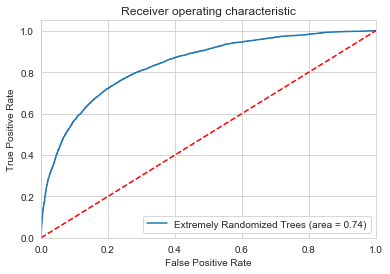

In [32]:
# Instantiate model 
ert = ExtraTreesClassifier(random_state = 42)

# Specify the hyperparameter to be tunned

ert_para={'n_estimators' : [100, 150, 200, 250, 300],
                 'max_depth':[10, 11, 12, 13, 14],
         'min_samples_split' : [13, 14, 15, 16, 17]}
# Create the RandomizedSearchCV object

cv_ert= RandomizedSearchCV(ert, ert_para, cv=5)

#  Fit to the training set

cv_ert.fit(X_train, y_train)

# predict the fitted data

y_pred_ert = cv_ert.predict(X_test)

# Compute and print metrics (roc_auc_score, accuracy score and classification_report) with the best model parameters

print('roc_auc_score:', roc_auc_score(y_test, y_pred_ert))   

print('accuracy_score:', accuracy_score(y_test, y_pred_ert))  

ert_prob = cv_ert.predict_proba(X_test)
ert_logloss = log_loss(y_test, ert_prob)
print('Log Loss for the ert: ', ert_logloss)  

print('confusion_matrix \n:', confusion_matrix(y_test, y_pred_ert))
print(classification_report(y_test, y_pred_ert))
print("Tuned Model Parameters: {}".format(cv_ert.best_params_))

                           

# draw the ROC_AUC curve

ert_roc = roc_auc_score(y_test, y_pred_ert)
fpr_ert, tpr_ert, thresholds_ert = roc_curve(y_test, cv_ert.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_ert, tpr_ert, label='Extremely Randomized Trees (area = %0.2f)' % ert_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ERT_ROC_curve')
plt.show()

# Gaussian NB

roc_auc_score: 0.7027154334922613
accuracy_score: 0.7026520225020091
Log Loss for the Gaussian NB :  0.9296105494540483
confusion_matrix 
: [[6523 2763]
 [1677 3969]]
              precision    recall  f1-score   support

         0.0       0.80      0.70      0.75      9286
         1.0       0.59      0.70      0.64      5646

    accuracy                           0.70     14932
   macro avg       0.69      0.70      0.69     14932
weighted avg       0.72      0.70      0.71     14932



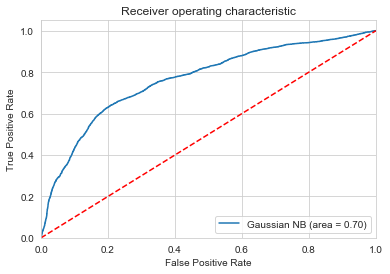

In [33]:
# Instantiate model 

gaus = GaussianNB()

#  Fit to the training set

gaus.fit(X_train, y_train)

# predict the fitted data

y_pred_gaus=gaus.predict(X_test)

# Compute and print metrics (roc_auc_score, accuracy score and classification_report) with the best model parameters

print('roc_auc_score:', roc_auc_score(y_test, y_pred_gaus))    

print('accuracy_score:', accuracy_score(y_test, y_pred_gaus))  

gaus_prob=gaus.predict_proba(X_test)
gaus_logloss = log_loss(y_test, gaus_prob)
print('Log Loss for the Gaussian NB : ', gaus_logloss)  

print('confusion_matrix \n:', confusion_matrix(y_test, y_pred_gaus))

print(classification_report(y_test, y_pred_gaus))



# draw the ROC_AUC curve

gaus_roc = roc_auc_score(y_test, y_pred_gaus)
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, gaus.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_gnb, tpr_gnb, label='Gaussian NB (area = %0.2f)' % gaus_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Gaussian_NB_ROC_curve')
plt.show()

# Gradient Boosting

roc_auc_score: 0.7669267224269063
accuracy_score: 0.7901151888561478
Log Loss for the Gradient Boosting Classifier :  0.44953482236931125
confusion_matrix 
: [[8005 1281]
 [1853 3793]]
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84      9286
         1.0       0.75      0.67      0.71      5646

    accuracy                           0.79     14932
   macro avg       0.78      0.77      0.77     14932
weighted avg       0.79      0.79      0.79     14932

Tuned Model Parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.2}


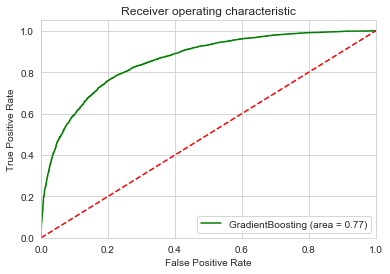

In [34]:
# Instantiate model 

gradb = GradientBoostingClassifier(random_state=37, max_features='sqrt')


gradb_para={'n_estimators' : [100, 150, 200, 250, 300, 350], 'learning_rate' : [0.20, 0.15, 0.1, 0.05, 0.01],
            'max_depth':[2,3,4,5]}

# Create the RandomizedSearchCV object

cv_gradb= RandomizedSearchCV(gradb, gradb_para, cv=5)

#  Fit to the training set

cv_gradb.fit(X_train, y_train)

# predict the fitted data

y_pred_gradb = cv_gradb.predict(X_test)

# Compute and print metrics (roc_auc_score, accuracy score and classification_report) with the best model parameters


print('roc_auc_score:', roc_auc_score(y_test, y_pred_gradb))    

print('accuracy_score:', accuracy_score(y_test, y_pred_gradb))       

gradb_prob = cv_gradb.predict_proba(X_test)
gradb_logloss = log_loss(y_test, gradb_prob)
print('Log Loss for the Gradient Boosting Classifier : ', gradb_logloss)

print('confusion_matrix \n:', confusion_matrix(y_test, y_pred_gradb))

print(classification_report(y_test, y_pred_gradb))

print("Tuned Model Parameters: {}".format(cv_gradb.best_params_)) 

# finaly ('learning_rate=0.15, n_estimators=100, max_depth=3, min_samples_leaf=3,min_samples_split=40, 
# random_state=37, max_features=7 ) are the hyper-parameters selected by the gridsearchCv object.




gradb_roc = roc_auc_score(y_test, y_pred_gradb)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, cv_gradb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_gb, tpr_gb, 'g', label='GradientBoosting (area = %0.2f)' % gradb_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Gradient_boosting_ROC_curve')
plt.show()

# Model Comparison By ROC AUC Curve

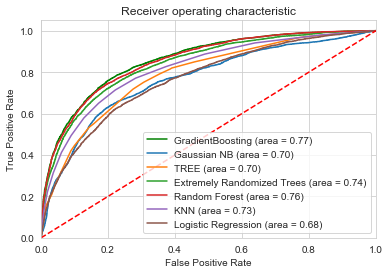

In [35]:

plt.figure()
plt.plot(fpr_gb, tpr_gb, 'g', label='GradientBoosting (area = %0.2f)' % gradb_roc)
plt.plot(fpr_gnb, tpr_gnb, label='Gaussian NB (area = %0.2f)' % gaus_roc)
plt.plot(fpr_tree, tpr_tree, label='TREE (area = %0.2f)' % tree_roc)
plt.plot(fpr_ert, tpr_ert, label='Extremely Randomized Trees (area = %0.2f)' % ert_roc)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc)
plt.plot(fpr_knn, tpr_knn, label='KNN (area = %0.2f)' % knn_roc)
plt.plot(fpr, tpr,label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_logreg))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Gradient_boosting_ROC_curve')
plt.show()

## 3. Briefly    discuss    how     Ultimate     might     leverage     the     insights    gained     from     the    model     to  improve     its     long­  term     rider     retention     (again,    a     few     sentences    will     suffice). 

## Best classifiers

roc_auc_score: 0.7682657395113475
accuracy_score: 0.7915215644253951
 Log Loss for the Gradient Boosting Classifier:  0.44857647082574165
confusion_matrix 
:               precision    recall  f1-score   support

         0.0       0.81      0.86      0.84      9286
         1.0       0.75      0.67      0.71      5646

    accuracy                           0.79     14932
   macro avg       0.78      0.77      0.77     14932
weighted avg       0.79      0.79      0.79     14932



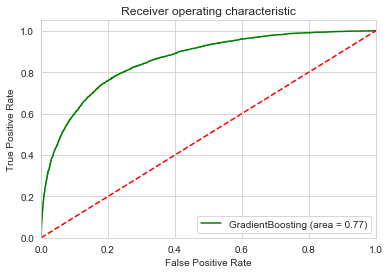

In [39]:
# Re run the gradient boosting algorithm using the optimized hyper parameters
# Instantiate model 

gradb0 = GradientBoostingClassifier(max_features='sqrt', random_state=42, n_estimators=250, learning_rate=0.2, max_depth= 4)


#  Fit to the training set

gradb0.fit(X_train, y_train)

# predict the fitted data

y_pred_gradb0 = gradb0.predict(X_test)

print('roc_auc_score:', roc_auc_score(y_test, y_pred_gradb0))    

print('accuracy_score:', accuracy_score(y_test, y_pred_gradb0))

gradb_prob0 =gradb0.predict_proba(X_test)
gradb_logloss0 = log_loss(y_test, gradb_prob0)
print(' Log Loss for the Gradient Boosting Classifier: ', gradb_logloss0)

print('confusion_matrix \n:', classification_report(y_test, y_pred_gradb0))
                               


gradb_roc = roc_auc_score(y_test, y_pred_gradb0)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, gradb0.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr_gb, tpr_gb, 'g', label='GradientBoosting (area = %0.2f)' % gradb_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Gradient_boosting_ROC_curve')
plt.show()

# Feature Importance using Gradient Boosting Algorithm

In [40]:
for name, importance in zip(X_train.columns, gradb0.feature_importances_):
    print(name, "=", importance)

trips_in_first_30_days = 0.04921061193497403
signup_date = 0.017076345695787327
avg_rating_of_driver = 0.02559543024887113
avg_surge = 0.12560395300854743
surge_pct = 0.07020263344467566
ultimate_black_user = 0.06881128663825727
weekday_pct = 0.17111820106605316
avg_dist = 0.03851312251082801
avg_rating_by_driver = 0.17700517899362933
phone_Android = 0.05117762706361805
phone_Other = 0.0007029544692706924
phone_iPhone = 0.03155436290443873
city_Astapor = 0.03270321744613773
city_King's Landing = 0.12670491505897855
city_Winterfell = 0.014020159515932957


## Visualizing Feature Importances using Gradient Boosting Algorithm

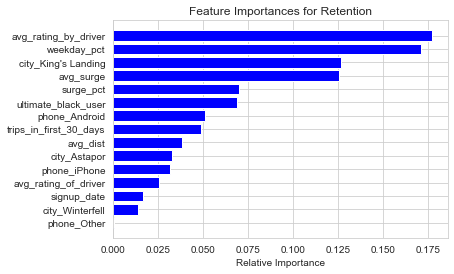

In [41]:
features = X_train.columns
importances = gradb0.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances for Retention')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


